In [1]:
%config InlineBackend.figure_formats = ['svg']
import sys
sys.path.insert(1, '../')

import matplotlib.pyplot as plt
from os import path

from deployment_instance import ExperimentResult
from src.ingest_data import ingest_experiment_results
from src.query_data import get_data_exfiltration_times, get_data_exfiltration_cdf
from statistics import mean
import seaborn as sns

import pandas as pd

In [2]:
# Baseline attacker
baseline_standalone_d0_h0 = ingest_experiment_results(path.join('data/Standalone/EquifaxLarge/baseline_standalone_d0_h0'))
baseline_standalone_d10_h50 = ingest_experiment_results(path.join('data/Standalone/EquifaxLarge/baseline_standalone_d10_h50'))
baseline_layered_d10_h50 = ingest_experiment_results(path.join('data/Layered/EquifaxLarge/baseline_layered_d10_h50'))

In [3]:
baseline_standalone_d0_h0_times = get_data_exfiltration_times(baseline_standalone_d0_h0, expected_files=48)
baseline_standalone_d10_h50_times = get_data_exfiltration_times(baseline_standalone_d10_h50, expected_files=48)
baseline_layered_d10_h50_times = get_data_exfiltration_times(baseline_layered_d10_h50, expected_files=48)

In [4]:
# merge dicts
all_data = {}
all_data.update(baseline_standalone_d0_h0)
all_data.update(baseline_standalone_d10_h50)
all_data.update(baseline_layered_d10_h50)

baseline_cdf = get_data_exfiltration_cdf(all_data, 48)

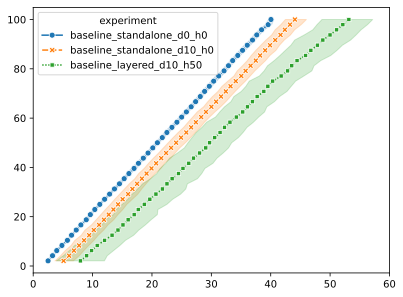

In [5]:
ax = sns.lineplot(data=baseline_cdf, 
             x="time_exfiltrated", y="percent_data", hue="experiment",
             style="experiment", markers=True, dashes=True, legend=True, orient="y")
# Remove x-axis label
ax.set(xlabel=None)
ax.set(ylabel=None)
ax.set_xlim(0, 60)

# Save as svg
plt = ax.get_figure()
plt.savefig('./plots/layered_exfil.svg', transparent=True)

In [6]:
# Print the mean time to exfiltrate
print("Mean time to exfiltrate: ")
print("Standalone: ", mean(baseline_standalone_d0_h0_times['time_exfiltrated']))
print("Standalone: ", mean(baseline_standalone_d10_h50_times['time_exfiltrated']))
print("% Increase: ", (mean(baseline_standalone_d10_h50_times['time_exfiltrated']) / mean(baseline_standalone_d0_h0_times['time_exfiltrated']) - 1) * 100)
print("Layered: ", mean(baseline_layered_d10_h50_times['time_exfiltrated']))
print("% Increase: ", (mean(baseline_layered_d10_h50_times['time_exfiltrated']) / mean(baseline_standalone_d0_h0_times['time_exfiltrated']) - 1) * 100)
print("% Increase: ", (mean(baseline_layered_d10_h50_times['time_exfiltrated']) / mean(baseline_standalone_d10_h50_times['time_exfiltrated']) - 1) * 100)

Mean time to exfiltrate: 
Standalone:  40.042714812854925
Standalone:  44.06876642862956
% Increase:  10.054392252350851
Layered:  53.157308268547055
% Increase:  32.7515092744959
% Increase:  20.623544919589733
